# Regression

In [1]:
# This code is supporting material for the book
# Building Machine Learning Systems with Python
# by Willi Richert, Luis Pedro Coelho and Matthieu Brucher
# published by PACKT Publishing
#
# It is made available under the MIT License

import numpy as np
from matplotlib import pyplot as plt

Use the magic command `%matplotlib` to see the plots inline:

In [2]:
%matplotlib inline

## Boston dataset

Load the data

In [3]:
from sklearn.datasets import load_boston
boston = load_boston()

The first regression attempt:

ValueError: Expected 2D array, got scalar array instead:
array=3.561.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

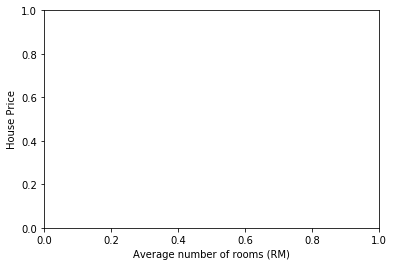

In [4]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=True)

# Index number five in the number of rooms
x = boston.data[:, 5]
y = boston.target

# lr.fit takes a two-dimensional array as input. We use np.atleast_2d
# to convert from one to two dimensional, then transpose to make sure that the
# format matches:
x = np.transpose(np.atleast_2d(x))
lr.fit(x, y)

fig,ax = plt.subplots()
ax.set_xlabel("Average number of rooms (RM)")
ax.set_ylabel("House Price")
xmin = x.min()
xmax = x.max()
ax.plot([xmin, xmax],
        [lr.predict(xmin), lr.predict(xmax)],
        '-', lw=2, color="#f9a602")
ax.scatter(x, y, s=2)
fig.savefig('Regression_Fig_01.png')

In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y, lr.predict(x))
print("Mean squared error (on training data): {:.3}".format(mse))

In [ ]:
rmse = np.sqrt(mse)
print('RMSE (on training data): {}'.format(rmse))

In [ ]:
from sklearn.metrics import r2_score
r2 = r2_score(y, lr.predict(x))
print("R2 (on training data): {:.2}".format(r2))

Repeat, but using all the input variables now

In [ ]:
x = boston.data

lr.fit(x,y)

mse = mean_squared_error(y, lr.predict(x))
print("Mean squared error (on training data): {:.3}".format(mse))
rmse = np.sqrt(mse)
print('RMSE (on training data): {}'.format(rmse))
r2 = r2_score(y, lr.predict(x))
print("R2 (on training data): {:.2}".format(r2))

To see how well we do, we plot _prediction vs. gold reality_:

In [ ]:
fig,ax = plt.subplots()
ax.set_xlabel('Predicted price')
ax.set_ylabel('Actual price')
ax.plot([y.min(), y.max()], [y.min(), y.max()], ':', lw=2, color="#f9a602")
ax.scatter(lr.predict(x), y, s=2)
fig.savefig("Regression_FIG_02.png")

Now, we will use **cross-validation** for evaluating the regression quality:

In [ ]:
from sklearn.model_selection import KFold, cross_val_predict
kf = KFold(n_splits=5)
p = cross_val_predict(lr, x, y, cv=kf)
rmse_cv = np.sqrt(mean_squared_error(p, y))
print('RMSE on 5-fold CV: {:.2}'.format(rmse_cv))

We now compare a few different regression models on _both training data and using cross-validation_:

In [ ]:
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge                              

for name, met in [
        ('linear regression', LinearRegression()),
        ('elastic-net(.5)', ElasticNet(alpha=0.5)),
        ('lasso(.5)', Lasso(alpha=0.5)),
        ('ridge(.5)', Ridge(alpha=0.5)),
]:
    # Fit on the whole data:
    met.fit(x, y)

    # Predict on the whole data:
    p = met.predict(x)
    r2_train = r2_score(y, p)

    kf = KFold(n_splits=5)
    p = np.zeros_like(y)
    for train, test in kf.split(x):
        met.fit(x[train], y[train])
        p[test] = met.predict(x[test])

        r2_cv = r2_score(y, p)
    print('Method: {}'.format(name))
    print('R2 on training: {:.2}'.format(r2_train))
    print('R2 on 5-fold CV: {:.2}'.format(r2_cv))
    print('\n')

In [ ]:
las = Lasso(normalize=True)                            
alphas = np.logspace(-5, 2, 1000)                   
alphas, coefs, _= las.path(x, y, alphas=alphas)     

fig,ax = plt.subplots()                             
ax.plot(alphas, coefs.T)                            
ax.set_xscale('log')                                
ax.set_xlim(alphas.max(), alphas.min())             


plt.title('Lasso coefficient path as a function of alpha')                                           
ax.set_xlabel('Alpha')                              
ax.set_ylabel('Coefficient weight')                 
fig.savefig('REGRESSION_FIG_03.png')

## Linear regression with Tensorflow

Let's try and do the same with Tensorflow.

In [ ]:
# Batch size, epochs
batch_size = 100
n_epochs = 50000
steps = 1000

In [ ]:
# Creation of the scaffolding

import tensorflow as tf
tf.reset_default_graph()

x = boston.data[:,5][:,None]
y = np.reshape(boston.target, (-1, 1))

nb_features = x.shape[1]

X = tf.placeholder(shape=[None, nb_features], dtype=tf.float32, name="X")
Y = tf.placeholder(shape=[None, 1], dtype=tf.float32, name="y")

A = tf.Variable(tf.random_normal(shape=[nb_features, 1]), name="A")
b = tf.Variable(tf.random_normal(shape=[1,1]), name="b")

In [ ]:
# Creation of the graph
model_output = tf.matmul(X, A) + b

loss = tf.reduce_mean(tf.square(Y - model_output))

# Uncomment to get Ridge or Lasso
"""
beta = 0.005
regularizer = tf.nn.l2_loss(A)
loss = loss + beta * regularizer
"""
"""
beta = 0.5
regularizer = tf.reduce_mean(tf.abs(A))
loss = loss + beta * regularizer
"""

grad_speed = 1e-3
my_opt = tf.train.GradientDescentOptimizer(grad_speed)
train_step = my_opt.minimize(loss)

In [ ]:
# Run the optimization
loss_vec = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(n_epochs):
        permut = np.random.permutation(len(x))
        for j in range(0, len(x), batch_size):
            batch = permut[j:j+batch_size]
            Xs = x[batch]
            Ys = y[batch]

            sess.run(train_step, feed_dict={X: Xs, Y: Ys})
            temp_loss = sess.run(loss, feed_dict={X: Xs, Y: Ys})
        
        if epoch % steps == steps - 1:
            temp_loss = sess.run(loss, feed_dict={X: x, Y: y})
            loss_vec.append(temp_loss)

            (A_, b_) = sess.run([A, b])
            print('Epoch #%i  A = %s b = %s' % (epoch, np.transpose(A_), b_))
            print('Loss = %.8f' % temp_loss)
            print("")


    [slope, y_intercept] = sess.run([A, b])
    prediction = sess.run(model_output, feed_dict={X: x})
    mse = mean_squared_error(y, prediction)
    print("Mean squared error (on training data): {:.3}".format(mse))
    rmse = np.sqrt(mse)
    print('RMSE (on training data): {}'.format(rmse))
    r2 = r2_score(y, prediction)
    print("R2 (on training data): {:.2}".format(r2))

best_fit = []
for i in x:
    best_fit.append(slope[0]*i+y_intercept[0])

In [ ]:
# Plot 1D best fit

fig,ax = plt.subplots()
ax.set_xlabel("Average number of rooms (RM)")
ax.set_ylabel("House Price")

ax.scatter(x, y, s=2, label='Data Points')
ax.plot(x, np.array(best_fit), '-', lw=2, color="#f9a602", label='Best fit line')
ax.legend(loc='upper left')

fig.savefig('REGRESSION_FIG_06.png')

# Plot loss over time
plt.figure()
fig,ax = plt.subplots()
ax.set_title('Loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

ax.plot(loss_vec, 'k-')

fig.savefig('REGRESSION_FIG_07.png')

What happens if we move to use all the features?

In [ ]:
# Creation of the scaffolding

import tensorflow as tf
tf.reset_default_graph()

x = boston.data
y = np.reshape(boston.target, (-1, 1))

nb_features = x.shape[1]

X = tf.placeholder(shape=[None, nb_features], dtype=tf.float32, name="X")
Y = tf.placeholder(shape=[None, 1], dtype=tf.float32, name="y")

A = tf.Variable(tf.random_normal(shape=[nb_features, 1]), name="A")
b = tf.Variable(tf.random_normal(shape=[1,1]), name="b")

In [ ]:
# Creation of the graph
model_output = tf.matmul(X, A) + b

loss = tf.reduce_mean(tf.square(Y - model_output))

# Uncomment to get Ridge or Lasso
"""
beta = 0.005
regularizer = tf.nn.l2_loss(A)
loss = loss + beta * regularizer
"""
"""
beta = 0.5
regularizer = tf.reduce_mean(tf.abs(A))
loss = loss + beta * regularizer
"""

grad_speed = 5e-7
my_opt = tf.train.GradientDescentOptimizer(grad_speed)
train_step = my_opt.minimize(loss)

In [ ]:
# Run the optimization
loss_vec = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(n_epochs):
        permut = np.random.permutation(len(x))
        for j in range(0, len(x), batch_size):
            batch = permut[j:j+batch_size]
            Xs = x[batch]
            Ys = y[batch]

            sess.run(train_step, feed_dict={X: Xs, Y: Ys})
            temp_loss = sess.run(loss, feed_dict={X: Xs, Y: Ys})
        
        if epoch % steps == steps - 1:
            temp_loss = sess.run(loss, feed_dict={X: x, Y: y})
            loss_vec.append(temp_loss)

            (A_, b_) = sess.run([A, b])
            print('Epoch #%i  A = %s b = %s' % (epoch, np.transpose(A_), b_))
            print('Loss = %.8f' % temp_loss)
            print("")


    [slope, y_intercept] = sess.run([A, b])
    prediction = sess.run(model_output, feed_dict={X: x})
    mse = mean_squared_error(y, prediction)
    print("Mean squared error (on training data): {:.3}".format(mse))
    rmse = np.sqrt(mse)
    print('RMSE (on training data): {}'.format(rmse))
    r2 = r2_score(y, prediction)
    print("R2 (on training data): {:.2}".format(r2))

best_fit = []
for i in x:
    best_fit.append(slope[0]*i+y_intercept[0])

In [ ]:
# Plot loss over time
plt.figure()
fig,ax = plt.subplots()
ax.set_title('Loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

ax.plot(loss_vec, 'k-')

fig.savefig('REGRESSION_FIG_08.png')

## E2006 Dataset

Load data:


In [ ]:
from sklearn.datasets import load_svmlight_file
data, target = load_svmlight_file('data/E2006.train')

Compute error on training data to demonstrate that we can obtain near perfect scores:

In [ ]:
lr = LinearRegression()
lr.fit(data, target)
pred = lr.predict(data) 

print('RMSE on training, {:.2}'.format(np.sqrt(mean_squared_error(target, pred))))
print('R2 on training, {:.2}'.format(r2_score(target, pred)))

However, we do not do so well on cross-validation:

In [ ]:
kf = KFold(n_splits=5)
pred = cross_val_predict(lr, data, target, cv=kf)

print('RMSE on testing (5 fold), {:.2}'.format(np.sqrt(mean_squared_error(target, pred))))
print('R2 on testing (5 fold), {:.2}'.format(r2_score(target, pred)))

Now, we try _an Elastic net_:

In [ ]:
# Edit the lines below if you want to switch method:                                                     
met = ElasticNet(alpha=0.1)
met.fit(data, target)
pred = met.predict(data)

print('[EN 0.1] RMSE on training: {:.2}'.format(np.sqrt(mean_squared_error(target, pred))))
print('[EN 0.1] R2 on training: {:.2}'.format(r2_score(target, pred)))

Not a perfect prediction on the training data anymore, but let us check the value on cross-validation:

In [ ]:
pred = cross_val_predict(met, data, target, cv=kf)

print('[EN 0.1] RMSE on testing (5 fold): {:.2}'.format(np.sqrt(mean_squared_error(target, pred))))
print('[EN 0.1] R2 on testing (5 fold): {:.2}'.format(r2_score(target, pred)))

We now use `ElasticNetCV` to set parameters automatically:

In [ ]:
from sklearn.linear_model import ElasticNetCV
# Construct an ElasticNetCV object (use all available CPUs)
met = ElasticNetCV(n_jobs=-1)

met.fit(data, target)
pred = met.predict(data)
print('[EN CV] RMSE on training, {:.2}'.format(np.sqrt(mean_squared_error(target, pred))))
print('[EN CV] R2 on training, {:.2}'.format(r2_score(target, pred)))

pred = cross_val_predict(met, data, target, cv=kf)
print('[EN CV] RMSE on testing (5 fold), {:.2}'.format(np.sqrt(mean_squared_error(target, pred))))
print('[EN CV] R2 on testing (5 fold), {:.2}'.format(r2_score(target, pred)))

This is a a pretty good general-purpose regression object:

In [ ]:
# Construct an ElasticNetCV object (use all available CPUs)
met = ElasticNetCV(n_jobs=-1, l1_ratio=[.01, .05, .25, .5, .75, .95, .99])

pred = cross_val_predict(met, data, target, cv=kf)

print('[EN CV l1_ratio] RMSE on testing(5 fold), {:.2}'.format(np.sqrt(mean_squared_error(target, pred))))
print('[EN CV l1_ratio] R2 on testing (5 fold), {:.2}'.format(r2_score(target, pred)))

Now the final result:

In [ ]:
fig, ax = plt.subplots()
ax.scatter(target, pred, c='k', s=1)
ax.plot([-5,-1], [-5,-1], 'r-', lw=2)
ax.set_xlabel('Actual value')
ax.set_ylabel('Predicted value')
fig.savefig('REGRESSION_FIG_05.png')